In [ ]:
import os
import glob
import numpy as np
import torch
from torchvision.models.inception import inception_v3
from torchvision import transforms
from PIL import Image
from scipy.linalg import sqrtm
from tqdm import tqdm
import clip

# ------------------------
# 1. 读取图像路径
# ------------------------

def load_image_paths(folder):
    return sorted(glob.glob(os.path.join(folder, "*.jpg")) + glob.glob(os.path.join(folder, "*.png")))

# ------------------------
# 2. 获取Inception特征（用于FID）
# ------------------------

def get_inception_activations(image_paths, model, device):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    model.eval()
    features = []

    with torch.no_grad():
        for path in tqdm(image_paths, desc="Extracting Inception Features"):
            image = Image.open(path).convert('RGB')
            img_tensor = transform(image).unsqueeze(0).to(device)
            feat = model(img_tensor)[0].cpu().numpy()
            features.append(feat)

    return np.array(features)

def calculate_fid(real_paths, gen_paths):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = torch.nn.Identity()

    act1 = get_inception_activations(real_paths, model, device)
    act2 = get_inception_activations(gen_paths, model, device)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# ------------------------
# 3. CLIP 相似度计算
# ------------------------

def calculate_clip_similarities(image_paths, captions):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    similarities = []

    for path, text in tqdm(zip(image_paths, captions), total=len(image_paths), desc="Calculating CLIP Similarities"):
        image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        text_token = clip.tokenize([text]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_token)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarity = (image_features @ text_features.T).item()
            similarities.append(similarity * 100)

    return similarities

# ------------------------
# 4. 主程序入口
# ------------------------

if __name__ == "__main__":
    # 替换为你的路径
    real_folder = "real_images"
    gen_folder = "gen_images"

    real_imgs = load_image_paths(real_folder)
    gen_imgs = load_image_paths(gen_folder)

    print(f"Found {len(real_imgs)} real and {len(gen_imgs)} generated images")

    # 计算 FID
    fid_score = calculate_fid(real_imgs[:len(gen_imgs)], gen_imgs)  # 截断以匹配数量
    print(f"\nFID Score: {fid_score:.2f}")

    # 构造对应的 captions（示例：默认用图像文件名构造）
    captions = [os.path.basename(p).replace("_", " ").replace("-", " ").split('.')[0] for p in gen_imgs]

    # 计算 CLIP 相似度
    clip_scores = calculate_clip_similarities(gen_imgs, captions)
    print("\nCLIP Similarity Scores (avg):", np.mean(clip_scores))


Found 3 real and 3 generated images
警告：图片数量过少（建议每类不少于50张），FID结果可能不可靠。


ValueError: The parameter 'aux_logits' expected value True but got False instead.

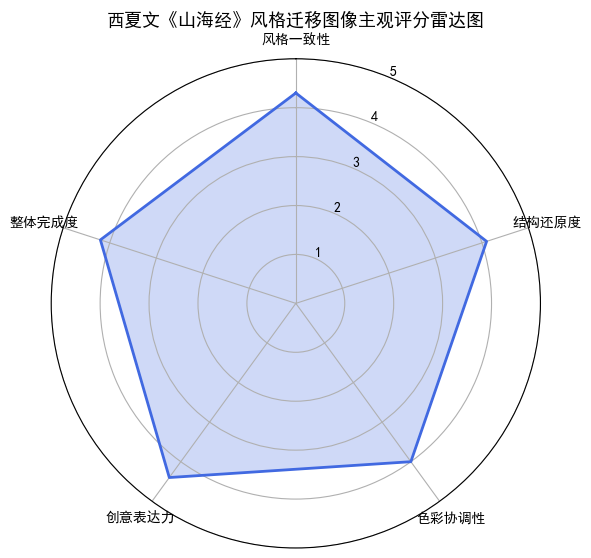

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# 中文字体设置
rcParams['font.sans-serif'] = ['SimHei']  # 设置为黑体
rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 五个主观评分维度
labels = ['风格一致性', '结构还原度', '色彩协调性', '创意表达力', '整体完成度']
num_vars = len(labels)

# 评分均值（示例）
scores = [4.3, 4.1, 4.0, 4.4, 4.2]
scores += scores[:1]  # 闭合雷达图

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# 雷达图绘制
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, scores, color='royalblue', linewidth=2)
ax.fill(angles, scores, color='royalblue', alpha=0.25)

# 设置坐标与标签
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 5)

# 设置标题
ax.set_title('西夏文《山海经》风格迁移图像主观评分雷达图', fontsize=13)

plt.tight_layout()
plt.show()


In [1]:
from safetensors import safe_open

with safe_open("models/hjq.safetensors", framework="pt", device="cpu") as f:
    keys = list(f.keys())
    print("LoRA 权重文件中的 keys:")
    for k in keys:
        print(k)


LoRA 权重文件中的 keys:
lora_te_text_model_encoder_layers_0_mlp_fc1.alpha
lora_te_text_model_encoder_layers_0_mlp_fc1.lora_down.weight
lora_te_text_model_encoder_layers_0_mlp_fc1.lora_up.weight
lora_te_text_model_encoder_layers_0_mlp_fc2.alpha
lora_te_text_model_encoder_layers_0_mlp_fc2.lora_down.weight
lora_te_text_model_encoder_layers_0_mlp_fc2.lora_up.weight
lora_te_text_model_encoder_layers_10_mlp_fc1.alpha
lora_te_text_model_encoder_layers_10_mlp_fc1.lora_down.weight
lora_te_text_model_encoder_layers_10_mlp_fc1.lora_up.weight
lora_te_text_model_encoder_layers_10_mlp_fc2.alpha
lora_te_text_model_encoder_layers_10_mlp_fc2.lora_down.weight
lora_te_text_model_encoder_layers_10_mlp_fc2.lora_up.weight
lora_te_text_model_encoder_layers_11_mlp_fc1.alpha
lora_te_text_model_encoder_layers_11_mlp_fc1.lora_down.weight
lora_te_text_model_encoder_layers_11_mlp_fc1.lora_up.weight
lora_te_text_model_encoder_layers_11_mlp_fc2.alpha
lora_te_text_model_encoder_layers_11_mlp_fc2.lora_down.weight
lora_te_te

In [1]:
from safetensors.torch import load_file

state_dict = load_file("models/hjq_2-000010.safetensors")

# 查找 text_encoder 部分的关键 key
for key in state_dict.keys():
    if "text_model.encoder.layers.0.self_attn.out_proj.lora_B.weight" in key:
        print("找到了关键 key：", key)
        break
else:
    print("未找到关键 key，可能权重不完整或损坏")


未找到关键 key，可能权重不完整或损坏
